# Test AI Engineer - Safepedia
<br>
Nama : Prinanda Rahmatullah
<br>
Email : prinanda50@gmail.com

## Extract and Split Data

In [ ]:
import os
import time
import shutil
import numpy as np
import random

from tqdm import tqdm

In [ ]:
target_type = "jpg"

# directory source dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/Technical Test AI Engineer - Prinanda Rahmatullah/data/training"

# directory of splitted dataset
split_data_path = "/content/minerals"
os.system(f"mkdir {split_data_path}")

training_data = f"{split_data_path}/training"
if not os.path.exists(training_data):
  os.makedirs(training_data)

validation_data = f"{split_data_path}/validation"
if not os.path.exists(validation_data):
  os.makedirs(validation_data)

!cp -rf "/content/drive/MyDrive/Colab Notebooks/Technical Test AI Engineer - Prinanda Rahmatullah/data/testing" "/content/minerals/testing"

In [ ]:
# load image from each classes and split into training+validation
division = 0.90
start_time = time.time()
for cls in os.listdir(data_path):
    number = 1
    class_path = os.path.join(data_path, cls)
    for img in tqdm(os.listdir(class_path), desc=cls):
      if img not in ['.ipynb_checkpoints']:
        img_path = os.path.join(class_path, img)
        # training data
        if number <= division * len(os.listdir(class_path)):
          dest_training_path = os.path.join(training_data, cls)
          if not os.path.exists(dest_training_path):
            os.makedirs(dest_training_path)
          os.symlink(img_path, f"{dest_training_path}/{img}")

        # validation
        else:
          dest_validation_path = os.path.join(validation_data, cls)
          if not os.path.exists(dest_validation_path):
            os.makedirs(dest_validation_path)
          os.symlink(img_path, os.path.join(dest_validation_path, img))

        number += 1

end_time = time.time()
print("\n--- %s seconds ---" % (end_time - start_time))

bornite: 100%|██████████| 173/173 [00:00<00:00, 788.77it/s]


--- 7.493873834609985 seconds ---


## Model

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Softmax, Flatten, Activation, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large, ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Loader

In [ ]:
def load_data(data_path, BS, is_train):
  if is_train:
    datagen = ImageDataGenerator(
            rescale=None,
            rotation_range=15,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode="nearest"
        )
  else:
    datagen = ImageDataGenerator(
        rescale=None
    )
  dataset = datagen.flow_from_directory(
      directory=data_path,
      target_size=(224, 224),
      class_mode="categorical",
      batch_size=BS,
      seed=51,
      shuffle=is_train
  )
  class_names = dataset.class_indices

  return dataset, class_names

### Initial

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Initiate Constant
BS = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
MODEL_NAME = f"MB3Large_Mineral_{BS}{EPOCHS}"
if not os.path.exists(f"/content/{MODEL_NAME}"):
  os.makedirs(f"/content/{MODEL_NAME}")

print("[INFO] Hyperparameter:")
print("Epoch: " + str(EPOCHS))
print("Learning rate: " + str(LEARNING_RATE))
print("Batch Size: " + str(BS))

[INFO] Hyperparameter:
Epoch: 50
Learning rate: 0.0001
Batch Size: 16


In [ ]:
# directory of train and test dataset
train_data_path = "/content/minerals/training"
list_training = list(os.listdir(train_data_path))
val_data_path = "/content/minerals/validation"
list_validation = list(os.listdir(val_data_path))
test_data_path = "/content/minerals/testing"
list_testing = list(os.listdir(test_data_path))

label_size = len(list_training)
print("Label Size:", label_size)

Label Size: 7


In [ ]:
# READ TRAIN, VAL, TEST DATA
train_dataset, train_class_names = load_data(train_data_path, BS, is_train=True)
val_dataset, val_class_names = load_data(val_data_path, BS, is_train=False)
test_dataset, test_class_names = load_data(test_data_path, BS, is_train=False)

Found 858 images belonging to 7 classes.
Found 94 images belonging to 7 classes.
Found 14 images belonging to 7 classes.


### CNN Architecture

In [ ]:
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) # COba tes pake MaxPooling atau Global
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(label_size, activation='softmax'))

12697600/12683000 [==============================] - 0s 0us/step


In [ ]:
opt = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# SUMMARY MODEL
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 960)              3840      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               246016    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
# Before training result
loss0, acc0 = model.evaluate(val_dataset)
loss_t0, acc_t0 = model.evaluate(test_dataset)

1/1 [==============================] - 0s 73ms/step - loss: 2.1974 - accuracy: 0.2143


In [ ]:
# Initiate Callbacks
model_callbacks = [
        EarlyStopping(monitor='val_loss', patience=11), # restore_best_weights=True
        CSVLogger(
            filename=f"/content/{MODEL_NAME}/history_e{EPOCHS}_bs{BS}.csv", separator=",", append=False),
        ModelCheckpoint(
            filepath=f"/content/{MODEL_NAME}/model_e{EPOCHS}_bs{BS}_val_loss.h5", monitor="val_loss", save_best_only=True),
        ModelCheckpoint(
            filepath=f"/content/{MODEL_NAME}/model_e{EPOCHS}_bs{BS}_val_acc.h5", monitor="val_accuracy", save_best_only=True)
    ]

### Training

In [ ]:
# Initiate start time
start_time = time.time()

# TRAIN MODEL
Historia = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks=model_callbacks,
    epochs=EPOCHS,
    batch_size=BS)

# end time
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
54/54 [==============================] - 215s 4s/step - loss: 2.4457 - accuracy: 0.2273 - val_loss: 1.6988 - val_accuracy: 0.3617
Epoch 2/50
54/54 [==============================] - 27s 496ms/step - loss: 1.5136 - accuracy: 0.4814 - val_loss: 1.2438 - val_accuracy: 0.5426
Epoch 3/50
54/54 [==============================] - 27s 500ms/step - loss: 1.0203 - accuracy: 0.6375 - val_loss: 1.0227 - val_accuracy: 0.6702
Epoch 4/50
54/54 [==============================] - 27s 503ms/step - loss: 0.7613 - accuracy: 0.7366 - val_loss: 0.9903 - val_accuracy: 0.6915
Epoch 5/50
54/54 [==============================] - 27s 495ms/step - loss: 0.5681 - accuracy: 0.7960 - val_loss: 0.8841 - val_accuracy: 0.7234
Epoch 6/50
54/54 [==============================] - 27s 496ms/step - loss: 0.4571 - accuracy: 0.8427 - val_loss: 0.8105 - val_accuracy: 0.7447
Epoch 7/50
54/54 [==============================] - 27s 493ms/step - loss: 0.3819 - accuracy: 0.8613 - val_loss: 0.8183 - val_accuracy: 0.7660
E

## Evaluation

### Function 

In [ ]:
# Font option
title_font = {'weight': 'medium', 'size': 'medium'}
axis_font = {'size': 'small'}


# Visualize accuracy from training model
def visualize_accuracy(Historia, MODEL_NAME, label_size, EPOCHS, BS):
    # xlimit
    Numero = np.arange(1, len(Historia.history["accuracy"])+1, 1)

    # plot accuracy
    plt.figure()
    plt.plot(Numero, Historia.history["accuracy"], label="train_acc")
    plt.plot(Numero, Historia.history["val_accuracy"], label="val_acc")
    plt.title("Training and Validation Accuracy on Dataset", **title_font)
    plt.xlabel(
        f"Epoch {EPOCHS} Batch Size {BS} Label {label_size}", **axis_font)
    plt.ylabel("Accuracy", **axis_font)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.grid()
    plt.savefig(
        f"/content/{MODEL_NAME}/figure_accuracy_{MODEL_NAME}_label{label_size}__e{EPOCHS}_bs{BS}.png", dpi=600)


# Visualize loss from training model
def visualize_loss(Historia, MODEL_NAME, label_size, EPOCHS, BS):
    # xlimit
    Numero = np.arange(1, len(Historia.history["loss"])+1, 1)

    # plot loss
    plt.figure()
    plt.plot(Numero, Historia.history["loss"], label="train_loss")
    plt.plot(Numero, Historia.history["val_loss"], label="val_loss")
    plt.title("Training and Validation Loss on Dataset", **title_font)
    plt.xlabel(
        f"Epoch {EPOCHS} Batch Size {BS} Label {label_size}", **axis_font)
    plt.ylabel("Loss", **axis_font)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.grid()
    plt.savefig(
        f"/content/{MODEL_NAME}/figure_loss_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.png", dpi=600)


# Print classification report to csv
def print_class_reports(tes, predictions, target_names, MODEL_NAME, label_size, EPOCHS, BS):
    report = classification_report(
        tes, predictions, target_names=target_names, output_dict=True)
    dataframe = pd.DataFrame(report).transpose()
    dataframe.to_csv(
        f"/content/{MODEL_NAME}/reports_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.csv")
    print(classification_report(tes, predictions, target_names=target_names))


# print confusion matrix and visualize it
def print_conf_matrix(tes, predictions, target_names, MODEL_NAME, label_size, EPOCHS, BS):
    confusion_mtx = confusion_matrix(tes, predictions)
    plt.figure()
    sns.heatmap(confusion_mtx, xticklabels=target_names, yticklabels=target_names,
                # annot=True,
                fmt='g',
                cbar_kws={'label': 'Individual Image'},
                )
    plt.title("Confusion Matrix on Prediction", **title_font)
    plt.xlabel('Prediction', **axis_font)
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.ylabel('Label', **axis_font)
    plt.tight_layout()
    plt.savefig(
        f"/content/{MODEL_NAME}/confusion_matrix_{MODEL_NAME}_label{label_size}_e{EPOCHS}_bs{BS}.png", dpi=600)
    print(confusion_mtx)


### After training result

In [ ]:
model = load_model(f"/content/{MODEL_NAME}/model_e{EPOCHS}_bs{BS}_val_loss.h5")

# evaluate
val_loss, val_acc = model.evaluate(val_dataset)
print(val_loss, val_acc)

test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

6/6 [==============================] - 3s 304ms/step - loss: 0.2983 - accuracy: 0.8830
0.29833531379699707 0.8829787373542786
1/1 [==============================] - 0s 76ms/step - loss: 0.1604 - accuracy: 0.9286
0.16036418080329895 0.9285714030265808


In [ ]:
# multi class case
predictions = np.argmax(model.predict(test_dataset), axis=1)
tes = test_dataset.classes

In [ ]:
# classification report
print_class_reports(tes, predictions, test_class_names, MODEL_NAME, label_size, EPOCHS, BS)

              precision    recall  f1-score   support

     biotite       1.00      1.00      1.00         2
     bornite       1.00      1.00      1.00         2
 chrysocolla       1.00      0.50      0.67         2
   malachite       0.67      1.00      0.80         2
   muscovite       1.00      1.00      1.00         2
      pyrite       1.00      1.00      1.00         2
      quartz       1.00      1.00      1.00         2

    accuracy                           0.93        14
   macro avg       0.95      0.93      0.92        14
weighted avg       0.95      0.93      0.92        14



[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 1 1 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


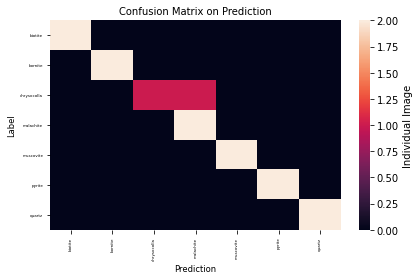

In [ ]:
# print confusion matrix
print_conf_matrix(tes, predictions, test_class_names, MODEL_NAME, label_size, EPOCHS, BS)

### Observe

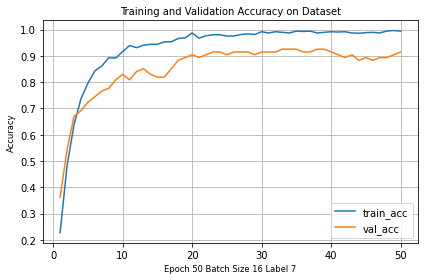

In [ ]:
# accuracy
visualize_accuracy(Historia, MODEL_NAME, label_size, EPOCHS, BS)

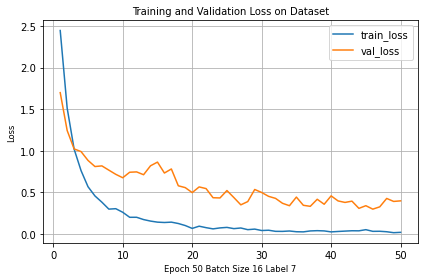

In [ ]:
# loss
visualize_loss(Historia, MODEL_NAME, label_size, EPOCHS, BS)

### Copy

In [ ]:
%cd /content
!zip -r /content/MB3Large_Mineral_1650.zip /content/MB3Large_Mineral_1650
!cp /content/MB3Large_Mineral_1650.zip "/content/drive/MyDrive/Colab Notebooks/Technical Test AI Engineer - Prinanda Rahmatullah/model/"

/content
  adding: content/MB3Large_Mineral_1650/ (stored 0%)
  adding: content/MB3Large_Mineral_1650/model_e50_bs16_val_loss.h5 (deflated 10%)
  adding: content/MB3Large_Mineral_1650/figure_accuracy_MB3Large_Mineral_1650_label7__e50_bs16.png (deflated 17%)
  adding: content/MB3Large_Mineral_1650/reports_MB3Large_Mineral_1650_label7_e50_bs16.csv (deflated 65%)
  adding: content/MB3Large_Mineral_1650/model_e50_bs16_val_acc.h5 (deflated 10%)
  adding: content/MB3Large_Mineral_1650/confusion_matrix_MB3Large_Mineral_1650_label7_e50_bs16.png (deflated 27%)
  adding: content/MB3Large_Mineral_1650/figure_loss_MB3Large_Mineral_1650_label7_e50_bs16.png (deflated 17%)
  adding: content/MB3Large_Mineral_1650/history_e50_bs16.csv (deflated 59%)


# Inference

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Technical Test AI Engineer - Prinanda Rahmatullah/model/MB3Large_Mineral_1650.zip" "/content"
!unzip "/content/MB3Large_Mineral_1650.zip"
!mkdir "minerals"
!cp -rf "/content/drive/MyDrive/Colab Notebooks/Technical Test AI Engineer - Prinanda Rahmatullah/data/testing" "minerals/"

In [ ]:
import os
import cv2
import numpy as np
from imutils import contours
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
model = load_model(f"content/MB3Large_Mineral_1650/model_e50_bs16_val_loss.h5")

In [ ]:
classes = sorted(os.listdir("/content/minerals/testing"))
classes

['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

In [ ]:
def predict_result(image_path):
    img = load_img(image_path)
    img = img_to_array(img.resize((224,224)))
    prediction = model.predict(np.expand_dims(img, axis=0))
    label = np.argmax(prediction, axis=1)
    return round(prediction[0][(label[0])]*100, 2), classes[label[0]]

In [ ]:
for cls in sorted(os.listdir("minerals/testing")):
  for img in sorted( os.listdir(f"minerals/testing/{cls}")):
    score, label = predict_result(os.path.join("minerals/testing", cls, img))
    print(score, img, label)

100.0 biotite1.jpg biotite
99.99 biotite2.jpg biotite
100.0 bornite1.jpg bornite
99.95 bornite2.jpg bornite
88.53 chrysocolla1.jpg malachite
99.86 chrysocolla2.jpg chrysocolla
100.0 malachite.jpg malachite
100.0 malachite1.jpg malachite
100.0 muscovite1.jpg muscovite
100.0 muscovite2.jpg muscovite
100.0 pyrite1.jpg pyrite
97.15 pyrite2.jpg pyrite
99.95 quartz1.jpg quartz
99.98 quartz2.jpg quartz


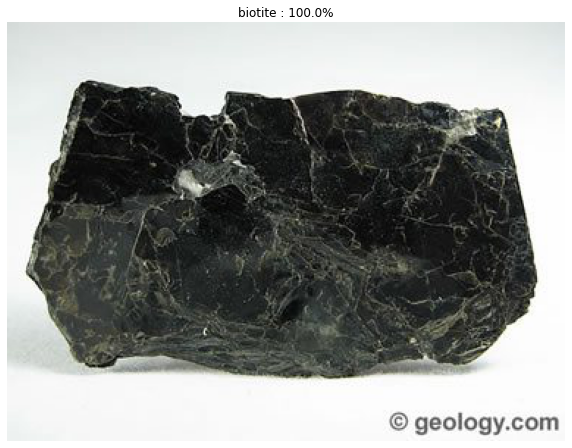

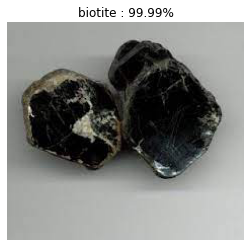

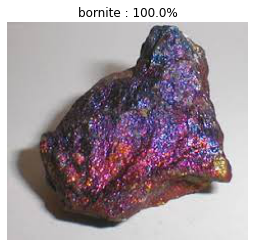

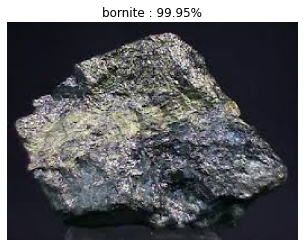

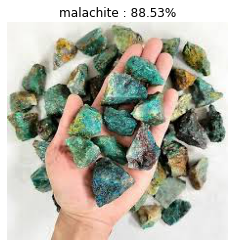

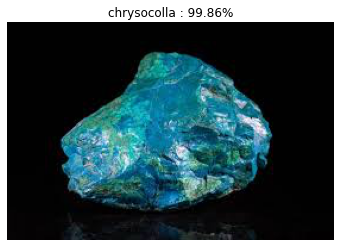

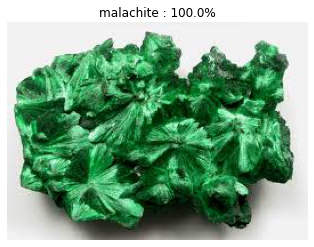

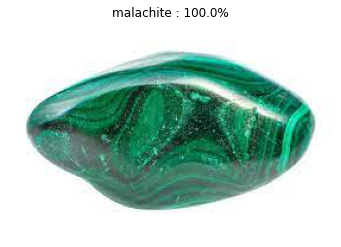

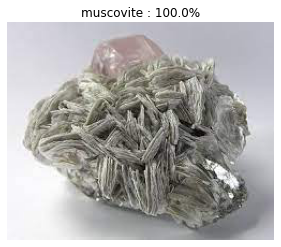

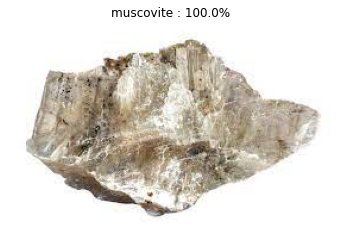

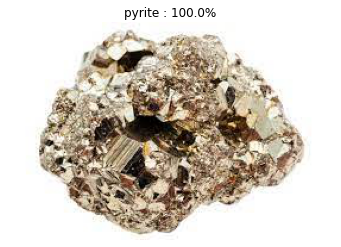

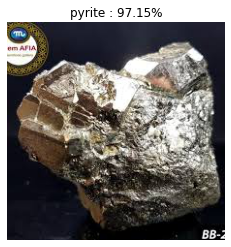

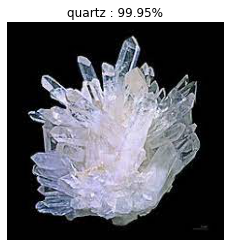

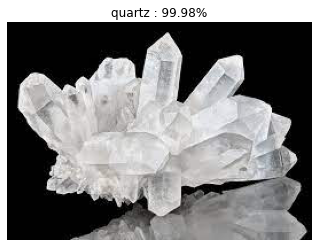

In [ ]:
# plot image with label
results = {}
plt.figure(figsize=(10,8))
for cls in sorted(os.listdir("minerals/testing")):
  for filename in sorted(os.listdir(f"minerals/testing/{cls}")):
    image_path = os.path.join("minerals","testing", cls, filename)
    image = plt.imread(image_path)
    imgplot = plt.imshow(image)
    score, label = predict_result(image_path)
    results[filename] = {"label":label, "confidence":score}
    plt.title(f"{label} : {score}%")
    plt.axis('off')
    plt.show()

### Dump to JSON

In [ ]:
import json

In [ ]:
with open("result.json","w") as doc:
  doc.write(json.dumps(results))

In [ ]:
!cp "/content/result.json" "/content/drive/MyDrive/Colab Notebooks/Technical Test AI Engineer - Prinanda Rahmatullah/"